## Setup

In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import tf_agents

In [2]:
from tf_agents.agents import DdpgAgent
from tf_agents.agents import ddpg

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

## Hyperparameters

In [4]:
# from Maxime
nb_actions = 10
replay_buffer_capacity = 1000
log_interval=100
eval_interval=1000

# from DQN Tutorial
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environement

In [5]:
class IArchitectEnv(py_environment.PyEnvironment):
    def __init__(self,verbose=False):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=nb_actions-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._state.shape[0],), dtype=np.int32, minimum=0, name='observation')
        
        self._episode_ended = False
        self.verbose = verbose
        self.REWARD = 100
        self.PENALTY_ALREADY_FILLED = -100
        self.DEFAULT_REWARD = 1

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._episode_ended = False
        return ts.restart(self._state)
#         return ts.restart(np.array([self._state], dtype=np.int32))


    def _step(self, action):
        """
        Remplit la action_ième case
        Retour une penalité si case est déjà remplie
        """
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Make sure episodes don't go on forever.
        action_ = action.round().astype(int)
        assert action_ in list(range(self._state.shape[0]))
        
        if self.verbose:
            print(self._state,action,action_)

        reward = self.DEFAULT_REWARD + self._state.sum()
        
        if self._state[action_]==1:
            reward = self.PENALTY_ALREADY_FILLED
            self._episode_ended = True

        self._state[action_]=1

        if self._state.sum()==self._state.shape[0]:
            self._episode_ended = True
            reward = self.REWARD
        
        if not self._episode_ended:
             result = ts.transition(
                self._state, reward=reward, discount=1)
#                 np.array([self._state], dtype=np.int32), reward=penalty, discount=0.95)
        
        else:
            result = ts.termination(self._state, reward)
#             return ts.termination(np.array([self._state], dtype=np.int32), reward)
        if self.verbose:
            print(result.observation,reward)
        return result


In [6]:
class MyObserver:
    def __init__(self,verbose=False):
        self.results = []
        self.verbose = verbose
    def __call__(self,traj):
        obs = traj.observation
        if isinstance(obs,Tensor):
            obs = obs.numpy().copy()
        else:
            obs = obs.copy()
        self.results.append({"observation":obs,"reward":traj.reward,"traj":traj})
        if self.verbose:
            print("\tMyObserver:",traj.observation,traj.reward)
    def plot(self):
        n = len(self.results)
        x = list(range(n))
        fig = plt.figure()
        plt.plot([t.get("reward") for t in self.results])
#         plt.bar(x=x,height=[int(t.get("traj").is_last())*8 for t in results],color="g")
#         plt.bar(x=x,height=[int(t.get("traj").is_boundary())*8 for t in results],color="r")
#         plt.bar(x=x,height=[int(t.get("traj").is_first())*8 for t in results],color="k")
        return fig

In [7]:
# Initialiser les environnement
environment = IArchitectEnv(verbose=True)
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

utils.validate_py_environment(environment, episodes=10)

[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 7 7
[0 0 0 0 0 0 1 1 0 0] 2
[0 0 0 0 0 0 1 1 0 0] 3 3
[0 0 0 1 0 0 1 1 0 0] 3
[0 0 0 1 0 0 1 1 0 0] 2 2
[0 0 1 1 0 0 1 1 0 0] 4
[0 0 1 1 0 0 1 1 0 0] 8 8
[0 0 1 1 0 0 1 1 1 0] 5
[0 0 1 1 0 0 1 1 1 0] 1 1
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 7 7
[0 1 1 1 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 2 2
[0 0 1 0 0 1 0 0 0 0] 2
[0 0 1 0 0 1 0 0 0 0] 4 4
[0 0 1 0 1 1 0 0 0 0] 3
[0 0 1 0 1 1 0 0 0 0] 9 9
[0 0 1 0 1 1 0 0 0 1] 4
[0 0 1 0 1 1 0 0 0 1] 9 9
[0 0 1 0 1 1 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 9 9
[0 0 0 0 0 0 0 0 1 1] 2
[0 0 0 0 0 0 0 0 1 1] 9 9
[0 0 0 0 0 0 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 9 9
[0 0 0 0 0 0 1 0 0 1] 2
[0 0 0 0 0 0 1 0 0 1] 8 8
[0 0 0 0 0 0 1 0 1 1] 3
[0 0 0 0 0 0 1 0 1 1] 9 9
[0 0 0 0 0 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

## Agent

In [8]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(environment.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [10]:
q_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1100      
_________________________________________________________________
dense_1 (Dense)              multiple                  5050      
_________________________________________________________________
dense_2 (Dense)              multiple                  510       
Total params: 6,660
Trainable params: 6,660
Non-trainable params: 0
_________________________________________________________________


## Policies

In [11]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [12]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Metrics

In [13]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [14]:
avg_return = compute_avg_return(eval_env, random_policy, num_eval_episodes)
returns = [avg_return]

[0 0 0 0 0 0 0 0 0 0] 2 2
[0 0 1 0 0 0 0 0 0 0] 1
[0 0 1 0 0 0 0 0 0 0] 8 8
[0 0 1 0 0 0 0 0 1 0] 2
[0 0 1 0 0 0 0 0 1 0] 8 8
[0 0 1 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 9 9
[0 0 0 0 0 0 0 0 1 1] 2
[0 0 0 0 0 0 0 0 1 1] 5 5
[0 0 0 0 0 1 0 0 1 1] 3
[0 0 0 0 0 1 0 0 1 1] 2 2
[0 0 1 0 0 1 0 0 1 1] 4
[0 0 1 0 0 1 0 0 1 1] 5 5
[0 0 1 0 0 1 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 6 6
[1 0 0 0 0 0 1 0 0 0] 2
[1 0 0 0 0 0 1 0 0 0] 6 6
[1 0 0 0 0 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 5 5
[1 0 0 0 0 1 0 0 0 0] 2
[1 0 0 0 0 1 0 0 0 0] 6 6
[1 0 0 0 0 1 1 0 0 0] 3
[1 0 0 0 0 1 1 0 0 0] 3 3
[1 0 0 1 0 1 1 0 0 0] 4
[1 0 0 1 0 1 1 0 0 0] 4 4
[1 0 0 1 1 1 1 0 0 0] 5
[1 0 0 1 1 1 1 0 0 0] 8 8
[1 0 0 1 1 1 1 0 1 0] 6
[1 0 0 1 1 1 1 0 1 0] 5 5
[1 0 0 1 1 1 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 0 0
[1 0 0 0 0 0

## Replay Buffer

In [15]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                data_spec=agent.collect_data_spec,                                                     
                                batch_size=train_env.batch_size,                                                             
                                max_length=100000)

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)
# Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [16]:
train_env.batch_size

1

In [17]:
collect_steps_per_iteration = 1
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                   sample_batch_size=batch_size, 
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


2022-03-02 10:59:34.935616: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
result_loss = []
num_iterations = 20000
train_env.reset()
for _ in range(batch_size):
    collect_step(train_env, agent.policy, replay_buffer)
for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        result_loss.append(train_loss)
    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(train_env, agent.policy, 5)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0

[0 1 0 0 0 1 0 0 0 1] 7 7
[0 1 0 0 0 1 0 1 0 1] 4
[0 1 0 0 0 1 0 1 0 1] 3 3
[0 1 0 1 0 1 0 1 0 1] 5
[0 1 0 1 0 1 0 1 0 1] 2 2
[0 1 1 1 0 1 0 1 0 1] 6
[0 1 1 1 0 1 0 1 0 1] 4 4
[0 1 1 1 1 1 0 1 0 1] 7
[0 1 1 1 1 1 0 1 0 1] 8 8
[0 1 1 1 1 1 0 1 1 1] 8
[0 1 1 1 1 1 0 1 1 1] 3 3
[0 1 1 1 1 1 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 4 4
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 9 9
[0 0 0 0 1 0 0 1 1 1] 4
[0 0 0 0 1 0 0 1 1 1] 9 9
[0 0 0 0 1 0

[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 9 9
[0 1 0 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 2 2
[0 0 1 0 0 0 0 0 0 0] 1
[0 0 1 0 0 0 0 0 0 0] 1 1
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 4 4
[0 1 1 0 1 0 0 1 0 1] 5
[0 1 1 0 1 0 0 1 0 1] 8 8
[0 1 1 0 1 0 0 1 1 1] 6
[0 1 1 0 1 0 0 1 1 1] 9 9
[0 1 1 0 1 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 7 7
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 8 8
[0 1 0 0 1 0 0 1 1 0] 4
[0 1 0 0 1 0 0 1 1 0] 9 9
[0 1 0 0 1 0 0 1 1 1] 5
[0 1 0 0 1 0 0 1 1 1] 9 9
[0 1 0 0 1 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 6 6
[0 0 0 0 1 0 1 0 0 0] 2
[0 0 0 0 1 0 1 0 0 0] 4 4
[0 0 0 0 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0

[0 0 0 1 0 0 0 1 1 0] 3 3
[0 0 0 1 0 0 0 1 1 0] -100
step = 20600: loss = 27.18239974975586
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 7 7
[1 0 0 0 0 0 0 1 0 0] 2
[1 0 0 0 0 0 0 1 0 0] 3 3
[1 0 0 1 0 0 0 1 0 0] 3
[1 0 0 1 0 0 0 1 0 0] 6 6
[1 0 0 1 0 0 1 1 0 0] 4
[1 0 0 1 0 0 1 1 0 0] 2 2
[1 0 1 1 0 0 1 1 0 0] 5
[1 0 1 1 0 0 1 1 0 0] 8 8
[1 0 1 1 0 0 1 1 1 0] 6
[1 0 1 1 0 0 1 1 1 0] 8 8
[1 0 1 1 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 8 8
[0 1 0 0 1 0 0 0 1 0] 3
[0 1 0 0 1 0 0 0 1 0] 5 5
[0 1 0 0 1 1 0 0 1 0] 4
[0 1 0 0 1 1 0 0 1 0] 7 7
[0 1 0 0 1 1 0 1 1 0] 5
[0 1 0 0 1 1 0 1 1 0] 8 8
[0 1 0 0 1 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 8 8
[0 0 0 0 1 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1

[0 1 1 0 1 1 0 1 0 0] 8 8
[0 1 1 0 1 1 0 1 1 0] 6
[0 1 1 0 1 1 0 1 1 0] 8 8
[0 1 1 0 1 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 6 6
[0 1 0 0 0 0 1 1 1 0] 4
[0 1 0 0 0 0 1 1 1 0] 7 7
[0 1 0 0 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 3 3
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 1 1
[0 1 0 1 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 8 8
[0 1 0 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 3 3
[0 0 0 1 1 0 0 1 1 0] 4
[0 0 0 1 1 0 0 1 1 0] 3 3
[0 0 0 1 1 0

[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 3 3
[0 0 0 1 0 0 0 1 0 0] 2
[0 0 0 1 0 0 0 1 0 0] 2 2
[0 0 1 1 0 0 0 1 0 0] 3
[0 0 1 1 0 0 0 1 0 0] 8 8
[0 0 1 1 0 0 0 1 1 0] 4
[0 0 1 1 0 0 0 1 1 0] 9 9
[0 0 1 1 0 0 0 1 1 1] 5
[0 0 1 1 0 0 0 1 1 1] 7 7
[0 0 1 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 3 3
[0 0 0 1 0 0 0 1 0 0] 2
[0 0 0 1 0 0 0 1 0 0] 2 2
[0 0 1 1 0 0 0 1 0 0] 3
[0 0 1 1 0 0 0 1 0 0] 4 4
[0 0 1 1 1 0 0 1 0 0] 4
[0 0 1 1 1 0 0 1 0 0] 4 4
[0 0 1 1 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 3 3
[0 0 0 1 1 0 0 1 0 0] 3
[0 0 0 1 1 0 0 1 0 0] 2 2
[0 0 1 1 1 0 0 1 0 0] 4
[0 0 1 1 1 0 0 1 0 0] 4 4
[0 0 1 1 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1

[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 4 4
[0 0 0 0 1 0 1 0 0 0] 2
[0 0 0 0 1 0 1 0 0 0] 6 6
[0 0 0 0 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 4 4
[0 0 0 0 1 0 1 0 0 0] 2
[0 0 0 0 1 0 1 0 0 0] 7 7
[0 0 0 0 1 0 1 1 0 0] 3
[0 0 0 0 1 0 1 1 0 0] 7 7
[0 0 0 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 3 3
[0 0 0 1 0 0 0 1 0 0] 2
[0 0 0 1 0 0 0 1 0 0] 6 6
[0 0 0 1 0 0 1 1 0 0] 3
[0 0 0 1 0 0 1 1 0 0] 2 2
[0 0 1 1 0 0 1 1 0 0] 4
[0 0 1 1 0 0 1 1 0 0] 2 2
[0 0 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 9 9
[0 1 0 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 9 9
[0 1 0 0 0 0 0 0 0 1] 2
[0 1 0 0 0 0 0 0 0 1] 2 2
[0 1 1 0 0 0

[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 8 8
[0 0 0 0 0 1 0 0 1 0] 2
[0 0 0 0 0 1 0 0 1 0] 5 5
[0 0 0 0 0 1 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 5 5
[0 1 0 0 0 1 0 0 1 0] 3
[0 1 0 0 0 1 0 0 1 0] 7 7
[0 1 0 0 0 1 0 1 1 0] 4
[0 1 0 0 0 1 0 1 1 0] 9 9
[0 1 0 0 0 1 0 1 1 1] 5
[0 1 0 0 0 1 0 1 1 1] 3 3
[0 1 0 1 0 1 0 1 1 1] 6
[0 1 0 1 0 1 0 1 1 1] 9 9
[0 1 0 1 0 1 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 3 3
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 6 6
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 2 2
[0 1 1 1 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 9 9
[0 1 0 0 0 0 0 0 1 1] 3
[0 1 0 0 0 0 0 0 1 1] 5 5
[0 1 0 0 0 1 0 0 1 1] 4
[0 1 0 0 0 1 0 0 1 1] 8 8
[0 1 0 0 0 1 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 8 8
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 9 9
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 9 9
[0 1 0 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 2 2
[0 0 1 0 0 0 0 0 0 0] 1
[0 0 1 0 0 0 0 0 0 0] 7 7
[0 0 1 0 0 0 0 1 0 0] 2
[0 0 1 0 0 0 0 1 0 0] 0 0
[1 0 1 0 0 0 0 1 0 0] 3
[1 0 1 0 0 0 0 1 0 0] 8 8
[1 0 1 0 0 0 0 1 1 0] 4
[1 0 1 0 0 0 0 1 1 0] 3 3
[1 0 1 1 0 0 0 1 1 0] 5
[1 0 1 1 0 0 0 1 1 0] 3 3
[1 0 1 1 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 3 3
[0 0 0 1 0 0 0 1 0 0] 2
[0 0 0 1 0 0 0 1 0 0] 9 9
[0 0 0 1 0 0 0 

[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 3 3
[0 0 0 1 1 0 0 1 0 0] 3
[0 0 0 1 1 0 0 1 0 0] 9 9
[0 0 0 1 1 0 0 1 0 1] 4
[0 0 0 1 1 0 0 1 0 1] 3 3
[0 0 0 1 1 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 5 5
[0 1 0 0 0 1 0 0 0 0] 2
[0 1 0 0 0 1 0 0 0 0] 7 7
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 2 2
[0 1 1 0 0 1 0 1 0 0] 4
[0 1 1 0 0 1 0 1 0 0] 3 3
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 2 2
[0 1 1 1 0 1 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 2 2
[0 0 1 0 0 1 0 0 0 0] 2
[0 0 1 0 0 1 0 0 0 0] 2 2
[0 0 1 0 0 1 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 2 2
[0 0 1 0 0 1 0 0 0 0] 2
[0 0 1 0 0 1 0 0 0 0] 2 2
[0 0 1 0 0 1 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 2 2
[0 0 1 0 1 0 0 0 0 0] 2
[0 0 1 0 1 0 0 0 0 0] 2 2
[0 0 1 0 1 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 1 1
[0 1 0 0 0 1 0 0 0 0] 2
[0 1 0 0 0 1 0 0 0 0] 2 2
[0 1 1 0 0 1 0 0 0 0] 3
[0 1 1 0 0 1 0 0 0 0] 2 2
[0 1 1 0 0 1 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 9 9
[0 1 0 0 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 9 9
[0 1 0 0 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 5 5
[0 1 0 0 0 1 0 0 0 0] 2
[0 1 0 0 0 1 0 0 0 0] 7 7
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 9 9
[0 1 0 0 0 1 0 1 0 1] 4
[0 1 0 0 0 1 0 1 0 1] 3 3
[0 1 0 1 0 1 0 1 0 1] 5
[0 1 0 1 0 1 0 1 0 1] 9 9
[0 1 0 1 0 1

[0 1 0 1 1 0 0 0 0 0] 8 8
[0 1 0 1 1 0 0 0 1 0] 4
[0 1 0 1 1 0 0 0 1 0] 7 7
[0 1 0 1 1 0 0 1 1 0] 5
[0 1 0 1 1 0 0 1 1 0] 3 3
[0 1 0 1 1 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 4 4
[0 0 0 0 1 1 0 0 0 0] 2
[0 0 0 0 1 1 0 0 0 0] 7 7
[0 0 0 0 1 1 0 1 0 0] 3
[0 0 0 0 1 1 0 1 0 0] 7 7
[0 0 0 0 1 1 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 2 2
[1 0 1 0 0 0 0 0 0 0] 2
[1 0 1 0 0 0 0 0 0 0] 4 4
[1 0 1 0 1 0 0 0 0 0] 3
[1 0 1 0 1 0 0 0 0 0] 3 3
[1 0 1 1 1 0 0 0 0 0] 4
[1 0 1 1 1 0 0 0 0 0] 8 8
[1 0 1 1 1 0 0 0 1 0] 5
[1 0 1 1 1 0 0 0 1 0] 6 6
[1 0 1 1 1 0 1 0 1 0] 6
[1 0 1 1 1 0 1 0 1 0] 4 4
[1 0 1 1 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 6 6
[0 0 0 0 1 0 1 1 1 0] 4
[0 0 0 0 1 0 1 1 1 0] 6 6
[0 0 0 0 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

[0 1 0 1 0 0 0 1 0 1] 9 9
[0 1 0 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 8 8
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 9 9
[0 1 0 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 8 8
[0 1 0 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 2 2
[0 0 1 0 0 0 0 0 0 0] 1
[0 0 1 0 0 0 0 0 0 0] 8 8
[0 0 1 0 0 0 0 0 1 0] 2
[0 0 1 0 0 0 0 0 1 0] 1 1
[0 1 1 0 0 0 0 0 1 0] 3
[0 1 1 0 0 0 0 0 1 0] 8 8
[0 1 1 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 7 7
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 8 8
[0 1 0 0 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 

[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 9 9
[0 1 0 0 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 9 9
[0 1 0 0 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 8 8
[0 1 0 0 0 0 0 1 1 1] 4
[0 1 0 0 0 0 0 1 1 1] 3 3
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 5 5
[0 1 0 1 0 1 0 1 1 1] 6
[0 1 0 1 0 1 0 1 1 1] 9 9
[0 1 0 1 0 1 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 3 3
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 9 9
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 3 3
[0 1 0 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

[0 1 0 1 1 0 0 0 0 0] 3 3
[0 1 0 1 1 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 4 4
[0 1 0 1 1 0 0 0 0 0] 3
[0 1 0 1 1 0 0 0 0 0] 8 8
[0 1 0 1 1 0 0 0 1 0] 4
[0 1 0 1 1 0 0 0 1 0] 9 9
[0 1 0 1 1 0 0 0 1 1] 5
[0 1 0 1 1 0 0 0 1 1] 3 3
[0 1 0 1 1 0 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 8 8
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 9 9
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 6 6
[0 1 0 1 0 0 1 1 1 1] 6
[0 1 0 1 0 0 1 1 1 1] 9 9
[0 1 0 1 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 9 9
[0 1 0 0 0 0 0 1 1 1] 4
[0 1 0 0 0 0 0 1 1 1] 8 8
[0 1 0 0 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 3 3
[0 1 0 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 9 9
[0 1 0 1 0 0 0 0 0 1] 3
[0 1 0 1 0 0 0 0 0 1] 0 0
[1 1 0 1 0 0 0 0 0 1] 4
[1 1 0 1 0 0 0 0 0 1] 3 3
[1 1 0 1 0 0 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 9 9
[0 1 0 1 0 0 0 0 0 1] 3
[0 1 0 1 0 0 0 0 0 1] 3 3
[0 1 0 1 0 0 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 1 1
[0 1 0 0 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 9 9
[0 1 0 0 0 0

[0 0 1 1 1 0 0 1 1 0] 3 3
[0 0 1 1 1 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 6 6
[0 1 0 0 0 0 1 0 0 0] 2
[0 1 0 0 0 0 1 0 0 0] 9 9
[0 1 0 0 0 0 1 0 0 1] 3
[0 1 0 0 0 0 1 0 0 1] 2 2
[0 1 1 0 0 0 1 0 0 1] 4
[0 1 1 0 0 0 1 0 0 1] 2 2
[0 1 1 0 0 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 1 1
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 8 8
[0 1 0 1 0 0 0 1 1 1] 5
[0 1 0 1 0 0 0 1 1 1] 9 9
[0 1 0 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 9 9
[0 1 0 0 0 0 0 0 0 1] 2
[0 1 0 0 0 0 0 0 0 1] 8 8
[0 1 0 0 0 0 0 0 1 1] 3
[0 1 0 0 0 0 0 0 1 1] 9 9
[0 1 0 0 0 0 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 

[0 1 1 1 0 0 0 0 0 1] 2 2
[0 1 1 1 0 0 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 3
[0 0 0 1 0 0 0 0 0 0] 1
[0 0 0 1 0 0 0 0 0 0] 2 2
[0 0 1 1 0 0 0 0 0 0] 2
[0 0 1 1 0 0 0 0 0 0] 8 8
[0 0 1 1 0 0 0 0 1 0] 3
[0 0 1 1 0 0 0 0 1 0] 9 9
[0 0 1 1 0 0 0 0 1 1] 4
[0 0 1 1 0 0 0 0 1 1] 1 1
[0 1 1 1 0 0 0 0 1 1] 5
[0 1 1 1 0 0 0 0 1 1] 3 3
[0 1 1 1 0 0 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 3 3
[0 1 0 1 0 0 0 0 1 0] 3
[0 1 0 1 0 0 0 0 1 0] 6 6
[0 1 0 1 0 0 1 0 1 0] 4
[0 1 0 1 0 0 1 0 1 0] 6 6
[0 1 0 1 0 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 7 7
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 3 3
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 8 8
[0 1 0 1 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0

[0 1 0 1 0 0 0 1 1 0] 5 5
[0 1 0 1 0 1 0 1 1 0] 5
[0 1 0 1 0 1 0 1 1 0] 6 6
[0 1 0 1 0 1 1 1 1 0] 6
[0 1 0 1 0 1 1 1 1 0] 2 2
[0 1 1 1 0 1 1 1 1 0] 7
[0 1 1 1 0 1 1 1 1 0] 4 4
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 8 8
[0 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 3 3
[0 0 0 1 1 0 0 1 1 0] 4
[0 0 0 1 1 0 0 1 1 0] 9 9
[0 0 0 1 1 0 0 1 1 1] 5
[0 0 0 1 1 0 0 1 1 1] 0 0
[1 0 0 1 1 0 0 1 1 1] 6
[1 0 0 1 1 0 0 1 1 1] 3 3
[1 0 0 1 1 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 9 9
[0 1 1 1 0 0 0 1 1 1] 6
[0 1 1 1 0 0 0 1 1 1] 3 3
[0 1 1 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[0 1 0 0 0 0 0 1 1 0] 3 3
[0 1 0 1 0 0 0 1 1 0] 4
[0 1 0 1 0 0 0 1 1 0] 6 6
[0 1 0 1 0 0 1 1 1 0] 5
[0 1 0 1 0 0 1 1 1 0] 2 2
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 8 8
[0 1 1 1 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 6 6
[0 1 0 0 0 0 1 0 1 0] 3
[0 1 0 0 0 0 1 0 1 0] 2 2
[0 1 1 0 0 0 1 0 1 0] 4
[0 1 1 0 0 0 1 0 1 0] 2 2
[0 1 1 0 0 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 3 3
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 2 2
[0 1 1 1 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 5 5
[0 1 0 1 0 1

[0 1 0 0 1 0 0 0 1 0] 3 3
[0 1 0 1 1 0 0 0 1 0] 4
[0 1 0 1 1 0 0 0 1 0] 6 6
[0 1 0 1 1 0 1 0 1 0] 5
[0 1 0 1 1 0 1 0 1 0] 4 4
[0 1 0 1 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 8 8
[0 1 0 0 1 0 0 0 1 0] 3
[0 1 0 0 1 0 0 0 1 0] 3 3
[0 1 0 1 1 0 0 0 1 0] 4
[0 1 0 1 1 0 0 0 1 0] 6 6
[0 1 0 1 1 0 1 0 1 0] 5
[0 1 0 1 1 0 1 0 1 0] 4 4
[0 1 0 1 1 0 1 0 1 0] -100
step = 24000: Average Return = -85.0
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 0 0
[1 1 0 0 0 0 0 0 0 0] 2
[1 1 0 0 0 0 0 0 0 0] 8 8
[1 1 0 0 0 0 0 0 1 0] 3
[1 1 0 0 0 0 0 0 1 0] 3 3
[1 1 0 1 0 0 0 0 1 0] 4
[1 1 0 1 0 0 0 0 1 0] 2 2
[1 1 1 1 0 0 0 0 1 0] 5
[1 1 1 1 0 0 0 0 1 0] 8 8
[1 1 1 1 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 3 3
[0 1 0 1 0 0 0 0 1 0] 3
[0 1 0 1 0 0 0 0 1 0] 4 4
[0 1 0 1 1 0 0 0 1 0] 4
[0 1

[0 0 0 0 0 0 0 0 0 0] 3 3
[0 0 0 1 0 0 0 0 0 0] 1
[0 0 0 1 0 0 0 0 0 0] 2 2
[0 0 1 1 0 0 0 0 0 0] 2
[0 0 1 1 0 0 0 0 0 0] 4 4
[0 0 1 1 1 0 0 0 0 0] 3
[0 0 1 1 1 0 0 0 0 0] 7 7
[0 0 1 1 1 0 0 1 0 0] 4
[0 0 1 1 1 0 0 1 0 0] 8 8
[0 0 1 1 1 0 0 1 1 0] 5
[0 0 1 1 1 0 0 1 1 0] 5 5
[0 0 1 1 1 1 0 1 1 0] 6
[0 0 1 1 1 1 0 1 1 0] 2 2
[0 0 1 1 1 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] 5
step = 24200: loss = 49.97947692871094
[0 1 1 1 0 0 1 1 0 0] 8 8
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 9 9
[0 1 1 1 0 0 1 1 1 1] 7
[0 1 1 1 0 0 1 1 1 1] 6 6
[0 1 1 1 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 6 6
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 8 8
[0 1 0 0 0 0 1 1 1 0] 4
[0 1 

[0 1 1 1 1 0 1 1 1 0] 8 8
[0 1 1 1 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 6 6
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 4 4
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 2 2
[0 1 1 1 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 8 8
[0 1 0 1 0 0 0 0 1 0] 3
[0 1 0 1 0 0 0 0 1 0] 6 6
[0 1 0 1 0 0 1 0 1 0] 4
[0 1 0 1 0 0 1 0 1 0] 4 4
[0 1 0 1 1 0 1 0 1 0] 5
[0 1 0 1 1 0 1 0 1 0] 2 2
[0 1 1 1 1 0 1 0 1 0] 6
[0 1 1 1 1 0 1 0 1 0] 8 8
[0 1 1 1 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 8 8
[0 0 0 0 1 0 0 1 1 0] 3
[0 0 0 0 1 0 0 1 1 0] 3 3
[0 0 0 1 1 0 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 3 3
[0 0 0 1 0 0 0 0 0 0] 1
[0 0 0 1 0 0 0 0 0 0] 1 1
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 2 2
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 6 6
[0 1 1 1 0 0 1 0 0 0] 4
[0 1 1 1 0 0 1 0 0 0] 4 4
[0 1 1 1 1 0 1 0 0 0] 5
[0 1 1 1 1 0 1 0 0 0] 2 2
[0 1 1 1 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 6 6
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 8 8
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 5 5
[0 1 1 0 0 1 1 1 1 0] 6
[0 1 1 0 0 1 1 1 1 0] 3 3
[0 1 1 1 0 1 1 1 1 0] 7
[0 1 1 1 0 1 1 1 1 0] 9 9
[0 1 1 1 0 1 1 1 1

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 9 9
[0 1 1 1 0 0 0 1 1 1] 6
[0 1 1 1 0 0 0 1 1 1] 6 6
[0 1 1 1 0 0 1 1 1 1] 7
[0 1 1 1 0 0 1 1 1 1] 8 8
[0 1 1 1 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 6 6
[0 1 0 1 0 0 1 0 0 0] 3
[0 1 0 1 0 0 1 0 0 0] 2 2
[0 1 1 1 0 0 1 0 0 0] 4
[0 1 1 1 0 0 1 0 0 0] 5 5
[0 1 1 1 0 1 1 0 0 0] 5
[0 1 1 1 0 1 1 0 0 0] 2 2
[0 1 1 1 0 1 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 8 8
[0 1 1 0 0 0 0 0 1 0] 3
[0 1 1 0 0 0 0 0 1 0] 9 9
[0 1 1 0 0 0 0 0 1 1] 4
[0 1 1 0 0 0 0 0 1 1] 3 3
[0 1 1 1 0 0 0 0 1 1] 5
[0 1 1 1 0 0 0 0 1 1] 9 9
[0 1 1 1 0 0 0 0 1

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 6 6
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 8 8
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 9 9
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 1 0 0 0 1 1 1 1] 6 6
[0 1 1 0 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 3 3
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 6 6
[0 1 1 1 0 0 1 0 0 0] 4
[0 1 1 1 0 0 1 0 0 0] 2 2
[0 1 1 1 0 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 3 3
[0 1 1 1 0 0 0 

[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 9 9
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 4 4
[0 1 1 1 1 0 0 1 0 1] 6
[0 1 1 1 1 0 0 1 0 1] 8 8
[0 1 1 1 1 0 0 1 1 1] 7
[0 1 1 1 1 0 0 1 1 1] 9 9
[0 1 1 1 1 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 8 8
[0 1 1 0 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 6 6
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 2 2
[0 1 1 0 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 6 6
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 6 6
[0 1 1 0 0 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 4 4
[0 1 1 0 1 0 0 0 0 0] 3
[0 1 1 0 1 0 0 0 0 0] 8 8
[0 1 1 0 1 0 0 0 1 0] 4
[0 1 1 0 1 0 0 0 1 0] 8 8
[0 1 1 0 1 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 5 5
[0 1 0 0 0 1 0 0 1 0] 3
[0 1 0 0 0 1 0 0 1 0] 0 0
[1 1 0 0 0 1 0 0 1 0] 4
[1 1 0 0 0 1 0 0 1 0] 7 7
[1 1 0 0 0 1 0 1 1 0] 5
[1 1 0 0 0 1 0 1 1 0] 8 8
[1 1 0 0 0 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 5 5
[0 1 0 0 0 1 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 9 9
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 8 8
[0 1 1 1 0 0 0 1 1 1] 6
[0 1 1 1 0 0 0 1 1 1] 3 3
[0 1 1 1 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 7 7
[0 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 9 9
[0 1 1 1 0 0 0 1 1

[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 3 3
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 2 2
[0 1 1 1 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 4 4
[0 1 0 1 1 0 1 1 0 0] 5
[0 1 0 1 1 0 1 1 0 0] 8 8
[0 1 0 1 1 0 1 1 1 0] 6
[0 1 0 1 1 0 1 1 1 0] 6 6
[0 1 0 1 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 7 7
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 3 3
[0 1 0 1 1 0 0 1 0 0] 4
[0 1 0 1 1 0 0 1 0 0] 8 8
[0 1 0 1 1 0 0 1 1 0] 5
[0 1 0 1 1 0 0 1 1 0] 6 6
[0 1 0 1 1 0 1 1 1 0] 6
[0 1 0 1 1 0 1 1 1 0] 5 5
[0 1 0 1 1 1 1 1 1 0] 7
[0 1 0 1 1 1 1 1 1 0] 2 2
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 4 4
[0 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[0 1 1 1 1 1 1 1 1 0] 6 6
[0 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 7 7
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 3 3
[0 1 0 1 1 0 0 1 0 0] 4
[0 1 0 1 1 0 0 1 0 0] 6 6
[0 1 0 1 1 0 1 1 0 0] 5
[0 1 0 1 1 0 1 1 0 0] 2 2
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 6 6
[0 1 1 1 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 6 6
[0 1 1 1 0 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 

[0 1 1 0 0 0 1 1 1 1] 4 4
[0 1 1 0 1 0 1 1 1 1] 7
[0 1 1 0 1 0 1 1 1 1] 3 3
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 9 9
[0 1 1 1 1 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 2 2
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 9 9
[0 1 1 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 9 9
[0 0 0 0 0 0 0 0 0 1] 1
[0 0 0 0 0 0 0 0 0 1] 1 1
[0 1 0 0 0 0 0 0 0 1] 2
[0 1 0 0 0 0 0 0 0 1] 3 3
[0 1 0 1 0 0 0 0 0 1] 3
[0 1 0 1 0 0 0 0 0 1] 1 1
[0 1 0 1 0 0 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 4 4
[0 1 0 1 1 0 0 0 0 0] 3
[0 1 0 1 1 0 0 0 0 0] 8 8
[0 1 0 1 1 0 0 0 1 0] 4
[0 1 0 1 1 0 0 0 1 0] 6 6
[0 1 0 1 1 0 1 0 1 0] 5
[0 1 0 1 1 0 1 0 1 0] 6 6
[0 1 0 1 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0

[0 1 1 0 1 1 1 1 1 1] 8 8
[0 1 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 6 6
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 4 4
[0 1 1 0 1 0 1 1 0 0] 5
[0 1 1 0 1 0 1 1 0 0] 1 1
[0 1 1 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 7 7
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 8 8
[0 1 0 0 1 0 0 1 1 0] 4
[0 1 0 0 1 0 0 1 1 0] 2 2
[0 1 1 0 1 0 0 1 1 0] 5
[0 1 1 0 1 0 0 1 1 0] 7 7
[0 1 1 0 1 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 4 4
[0 1 1 0 1 0 0 0 0 0] 3
[0 1 1 0 1 0 0 0 0 0] 8 8
[0 1 1 0 1 0 0 0 1 0] 4
[0 1 1 0 1 0 0 0 1 0] 3 3
[0 1 1 1 1 0 0 0 1 0] 5
[0 1 1 1 1 0 0 0 1 0] 9 9
[0 1 1 1 1 0 0 0 1 1] 6
[0 1 1 1 1 0 0 0 1 1] 6 6
[0 1 1 1 1 0 1 

[0 1 0 1 1 0 0 1 1 0] 6 6
[0 1 0 1 1 0 1 1 1 0] 6
[0 1 0 1 1 0 1 1 1 0] 2 2
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 9 9
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 6 6
[0 1 1 1 1 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 2 2
[1 0 1 0 0 0 0 0 0 0] 2
[1 0 1 0 0 0 0 0 0 0] 8 8
[1 0 1 0 0 0 0 0 1 0] 3
[1 0 1 0 0 0 0 0 1 0] 1 1
[1 1 1 0 0 0 0 0 1 0] 4
[1 1 1 0 0 0 0 0 1 0] 6 6
[1 1 1 0 0 0 1 0 1 0] 5
[1 1 1 0 0 0 1 0 1 0] 9 9
[1 1 1 0 0 0 1 0 1 1] 6
[1 1 1 0 0 0 1 0 1 1] 2 2
[1 1 1 0 0 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 9 9
[0 1 1 0 0 0 0 1 1 1] 5
[0 1 1 0 0 0 0 1 1 1] 6 6
[0 1 1 0 0 0 1 

[0 1 1 1 0 0 1 0 0 1] 8 8
[0 1 1 1 0 0 1 0 1 1] 6
[0 1 1 1 0 0 1 0 1 1] 9 9
[0 1 1 1 0 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 3 3
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 9 9
[0 1 1 1 0 0 0 0 0 1] 4
[0 1 1 1 0 0 0 0 0 1] 6 6
[0 1 1 1 0 0 1 0 0 1] 5
[0 1 1 1 0 0 1 0 0 1] 4 4
[0 1 1 1 1 0 1 0 0 1] 6
[0 1 1 1 1 0 1 0 0 1] 2 2
[0 1 1 1 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 4 4
[0 1 1 0 1 0 0 0 0 0] 3
[0 1 1 0 1 0 0 0 0 0] 3 3
[0 1 1 1 1 0 0 0 0 0] 4
[0 1 1 1 1 0 0 0 0 0] 6 6
[0 1 1 1 1 0 1 0 0 0] 5
[0 1 1 1 1 0 1 0 0 0] 4 4
[0 1 1 1 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 

[0 1 1 0 1 1 1 1 1 0] 9 9
[0 1 1 0 1 1 1 1 1 1] 8
[0 1 1 0 1 1 1 1 1 1] 5 5
[0 1 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 5 5
[0 1 0 0 0 1 0 1 1 0] 4
[0 1 0 0 0 1 0 1 1 0] 4 4
[0 1 0 0 1 1 0 1 1 0] 5
[0 1 0 0 1 1 0 1 1 0] 2 2
[0 1 1 0 1 1 0 1 1 0] 6
[0 1 1 0 1 1 0 1 1 0] 4 4
[0 1 1 0 1 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 4 4
[0 1 0 0 1 0 0 0 0 0] 2
[0 1 0 0 1 0 0 0 0 0] 7 7
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 8 8
[0 1 0 0 1 0 0 1 1 0] 4
[0 1 0 0 1 0 0 1 1 0] 5 5
[0 1 0 0 1 1 0 1 1 0] 5
[0 1 0 0 1 1 0 1 1 0] 2 2
[0 1 1 0 1 1 0 1 1 0] 6
[0 1 1 0 1 1 0 1 1 0] 3 3
[0 1 1 1 1 1 0 1 1 0] 7
[0 1 1 1 1 1 0 1 1 0] 8 8
[0 1 1 1 1 1 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 2 2
[0 1 1 1 0 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 9 9
[0 1 0 1 0 0 0 1 0 1] 4
[0 1 0 1 0 0 0 1 0 1] 2 2
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 6 6
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 2 2
[0 1 1 1 0 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 2 2
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 4 4
[0 1 1 1 1 0 0 0 0 0] 4
[0 1 1 1 1 0 0 0 0 0] 6 6
[0 1 1 1 1 0 1 0 0 0] 5
[0 1 1 1 1 0 1 0 0 0] 2 2
[0 1 1 1 1 0 1 0 0

[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 6 6
[0 1 1 1 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
step = 27200: loss = 59.89873504638672
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 0 0
[1 1 0 1 0 0 1 1 0 0] 5
[1 1 0 1 0 0 1 1 0 0] 2 2
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 8 8
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 9 9
[1 1 1 1 0 0 1 1 1 1] 8
[1 1 1 1 0 0 1 1 1 1] 6 6
[1 1 1 1 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 6 6
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 9 9
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 

[0 1 1 0 0 0 1 1 1 0] 9 9
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 1 0 0 0 1 1 1 1] 6 6
[0 1 1 0 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 4 4
[0 1 1 0 1 0 1 1 0 0] 5
[0 1 1 0 1 0 1 1 0 0] 2 2
[0 1 1 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 4 4
[0 1 1 0 1 0 1 1 0 0] 5
[0 1 1 0 1 0 1 1 0 0] 2 2
[0 1 1 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
step = 27400: loss = 94.6539535522461
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1 0] 5
[0 

[0 1 1 1 0 0 1 1 1 1] 9 9
[0 1 1 1 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 9 9
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 6 6
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 4 4
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 6 6
[0 1 1 1 1 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 9 9
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 2 2
[0 1 1 1 0 0 0 1 0 1] -100
step = 27600: loss = 88.116943359375
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 5 5
[0 1 0 0 0 1 0 1 0 0] 3
[0 1

[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 8 8
[1 1 1 0 0 0 0 1 1 1] 6
[1 1 1 0 0 0 0 1 1 1] 8 8
[1 1 1 0 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 9 9
[0 1 1 0 0 0 0 1 1 1] 5
[0 1 1 0 0 0 0 1 1 1] 0 0
[1 1 1 0 0 0 0 1 1 1] 6
[1 1 1 0 0 0 0 1 1 1] 6 6
[1 1 1 0 0 0 1 1 1 1] 7
[1 1 1 0 0 0 1 1 1 1] 5 5
[1 1 1 0 0 1 1 1 1 1] 8
[1 1 1 0 0 1 1 1 1 1] 3 3
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 9 9
[1 1 1 1 0 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 9 9
[0 1 1 0 0 0 0 1 1 1] 5
[0 1 1 0 0 0 0 1 1 1] 6 6
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 1 0 0 0 1 1 1 1] 4 4
[0 1 1 0 1 0 1 1 1

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 7 7
[0 1 1 1 0 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 5 5
[0 1 1 1 1 1 1 1 0 0] 7
[0 1 1 1 1 1 1 1 0 0] 9 9
[0 1 1 1 1 1 1 1 0 1] 8
[0 1 1 1 1 1 1 1 0 1] 8 8
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 2 2
[0 1 1 1 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 8 8
[0 1 1 1 0 0 0 1 1

[0 1 1 1 0 0 1 1 1 1] 4 4
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 9 9
[0 1 1 1 1 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 1 1
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 9 9
[0 1 1 1 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 0 0
[1 1 0 0 0 0

[0 1 0 0 0 0 0 1 0 0] 6 6
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 8 8
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 9 9
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 1 0 0 0 1 1 1 1] 9 9
[0 1 1 0 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 6 6
[0 1 0 0 0 0 1 0 0 0] 2
[0 1 0 0 0 0 1 0 0 0] 9 9
[0 1 0 0 0 0 1 0 0 1] 3
[0 1 0 0 0 0 1 0 0 1] 2 2
[0 1 1 0 0 0 1 0 0 1] 4
[0 1 1 0 0 0 1 0 0 1] 3 3
[0 1 1 1 0 0 1 0 0 1] 5
[0 1 1 1 0 0 1 0 0 1] 4 4
[0 1 1 1 1 0 1 0 0 1] 6
[0 1 1 1 1 0 1 0 0 1] 8 8
[0 1 1 1 1 0 1 0 1 1] 7
[0 1 1 1 1 0 1 0 1 1] 0 0
[1 1 1 1 1 0 1 0 1 1] 8
[1 1 1 1 1 0 1 0 1 1] 6 6
[1 1 1 1 1 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 

[0 1 1 0 0 0 0 1 1 1] 0 0
[1 1 1 0 0 0 0 1 1 1] 6
[1 1 1 0 0 0 0 1 1 1] 6 6
[1 1 1 0 0 0 1 1 1 1] 7
[1 1 1 0 0 0 1 1 1 1] 4 4
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 3 3
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 4 4
[0 1 1 0 1 0 0 0 0 0] 3
[0 1 1 0 1 0 0 0 0 0] 7 7
[0 1 1 0 1 0 0 1 0 0] 4
[0 1 1 0 1 0 0 1 0 0] 3 3
[0 1 1 1 1 0 0 1 0 0] 5
[0 1 1 1 1 0 0 1 0 0] 6 6
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 6 6
[0 1 1 1 1 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 8 8
[0 1 1 1 0 0 1 1 1 1] 7
[0 1 1 1 0 0 1 1 1 1] 5 5
[0 1 1 1 0 1 1 1 1 1] 8
[0 1 1 1 0 1 1 1 1 1] 5 5
[0 1 1 1 0 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 0 0
[1 1 1 0 0 0 0 1 1 0] 5
[1 1 1 0 0 0 0 1 1 0] 3 3
[1 1 1 1 0 0 0 1 1 0] 6
[1 1 1 1 0 0 0 1 1 0] 5 5
[1 1 1 1 0 1 0 1 1 0] 7
[1 1 1 1 0 1 0 1 1 0] 9 9
[1 1 1 1 0 1 0 1 1 1] 8
[1 1 1 1 0 1 0 1 1 1] 6 6
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 0 0
[1 1 1 1 0 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0

[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 0 0
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 8 8
[1 1 1 1 0 0 1 1 1 1] 8
[1 1 1 1 0 0 1 1 1 1] 5 5
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 9 9
[1 1 1 1 0 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 5 5
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 2 2
[0 1 1 0 0 1 0 1 0 0] 4
[0 1 1 0 0 1 0 1 0 0] 3 3
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 6 6
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 4 4
[0 1 1 1 1 1 1 1 0 0] 7
[0 1 1 1 1 1 1 1 0 0] 9 9
[0 1 1 1 1 1 1 1 0 1] 8
[0 1 1 1 1 1 1 1 0 1] 0 0
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 6 6
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[0 1 1 1 0 1 0 1 0 0] 4 4
[0 1 1 1 1 1 0 1 0 0] 6
[0 1 1 1 1 1 0 1 0 0] 9 9
[0 1 1 1 1 1 0 1 0 1] 7
[0 1 1 1 1 1 0 1 0 1] 0 0
[1 1 1 1 1 1 0 1 0 1] 8
[1 1 1 1 1 1 0 1 0 1] 5 5
[1 1 1 1 1 1 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 5 5
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 4 4
[0 1 1 1 1 1 0 1 0 0] 6
[0 1 1 1 1 1 0 1 0 0] 9 9
[0 1 1 1 1 1 0 1 0 1] 7
[0 1 1 1 1 1 0 1 0 1] 4 4
[0 1 1 1 1 1 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 5 5
[0 1 1 1 0 1 1 1 0 1] 7
[0 1 1 1 0 1 1 1 0 1] 0 0
[1 1 1 1 0 1 1 1 0

[1 1 1 1 0 1 0 0 1 0] 9 9
[1 1 1 1 0 1 0 0 1 1] 7
[1 1 1 1 0 1 0 0 1 1] 0 0
[1 1 1 1 0 1 0 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 8 8
[0 1 1 1 0 0 1 1 1 1] 7
[0 1 1 1 0 0 1 1 1 1] 5 5
[0 1 1 1 0 1 1 1 1 1] 8
[0 1 1 1 0 1 1 1 1 1] 0 0
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 5 5
[1 1 1 1 0 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 0 0
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 8 8
[1 1 1 1 0 0 1 1 1

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 9 9
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 9 9
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 0 0
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 4 4
[0 1 1 0 1 0 0 1 0 0] 4
[0 1 1 0 1 0 0 1 0 0] 8 8
[0 1 1 0 1 0 0 1 1 0] 5
[0 1 1 0 1 0 0 1 1 0] 3 3
[0 1 1 1 1 0 0 1 1 0] 6
[0 1 1 1 1 0 0 1 1 0] 6 6
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 5 5
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 4 4
[0 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 1 1
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 2 2
[0 1 1 0 0 0 0 0 1 0] 3
[0 1 1 0 0 0 0 0 1 0] 4 4
[0 1 1 0 1 0 0 0 1 0] 4
[0 1 1 0 1 0 0 0 1 0] 5 5
[0 1 1 0 1 1 0 0 1 0] 5
[0 1 1 0 1 1 0 0 1 0] 3 3
[0 1 1 1 1 1 0 0 1 0] 6
[0 1 1 1 1 1 0 0 1 0] 6 6
[0 1 1 1 1 1 1 0 1 0] 7
[0 1 1 1 1 1 1 0 1 0] 4 4
[0 1 1 1 1 1 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 6 6
[0 1 0 1 0 0 1 1 0 0] 4
[0 1 0 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 9 9
[0 1 0 0 0 0 0 0 0 1] 2
[0 1 0 0 0 0 0 0 0 1] 7 7
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 2 2
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 8 8
[1 1 1 0 0 0 0 1 1 1] 6
[1 1 1 0 0 0 0 1 1 1] 3 3
[1 1 1 1 0 0 0 1 1 1] 7
[1 1 1 1 0 0 0 1 1 1] 6 6
[1 1 1 1 0 0 1 1 1 1] 8
[1 1 1 1 0 0 1 1 1 1] 5 5
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 4 4
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 9 9
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 4 4
[0 1 1 1 1 1 1 1 1 1] 

[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 5 5
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 4 4
[0 1 1 1 1 1 0 1 0 0] 6
[0 1 1 1 1 1 0 1 0 0] 8 8
[0 1 1 1 1 1 0 1 1 0] 7
[0 1 1 1 1 1 0 1 1 0] 9 9
[0 1 1 1 1 1 0 1 1 1] 8
[0 1 1 1 1 1 0 1 1 1] 0 0
[1 1 1 1 1 1 0 1 1 1] 9
[1 1 1 1 1 1 0 1 1 1] 5 5
[1 1 1 1 1 1 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 5 5
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 4 4
[0 1 1 1 1 1 0 1 0 0] 6
[0 1 1 1 1 1 0 1 0 0] 8 8
[0 1 1 1 1 1 0 1 1 0] 7
[0 1 1 1 1 1 0 1 1 0] 9 9
[0 1 1 1 1 1 0 1 1 1] 8
[0 1 1 1 1 1 0 1 1 1] 0 0
[1 1 1 1 1 1 0 1 1 1] 9
[1 1 1 1 1 1 0 1 1 1] 5 5
[1 1 1 1 1 1 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0

[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 5 5
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 4 4
[0 1 1 1 1 1 1 1 0 0] 7
[0 1 1 1 1 1 1 1 0 0] 8 8
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 5 5
[0 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 5 5
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 0 0
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 

[1 1 0 1 0 1 0 1 0 0] 0 0
[1 1 0 1 0 1 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 3 3
[1 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 5 5
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 9 9
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 5 5
[1 1 1 1 0 1 0 1 0 0] 6
[1 1 1 1 0 1 0 1 0 0] 4 4
[1 1 1 1 1 1 0 1 0 0] 7
[1 1 1 1 1 1 0 1 0 0] 9 9
[1 1 1 1 1 1 0 1 0 1] 8
[1 1 1 1 1 1 0 1 0 1] 6 6
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 5 5
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 4 4
[0 1 1 1 1 1 0 1 0 0] 6
[0 1 1 1 1 1 0 1 0 0] 0 0
[1 1 1 1 1 1 0 1 0 0] 7
[1 1 1 1 1 1 0 1 0 0] 2 2
[1 1 1 1 1 1 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 1 1
[1 1 1 0 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 6 6
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 3 3
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 5 5
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 4 4
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 0 0
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0

[1 1 1 1 1 0 1 1 0 0] 5 5
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 9 9
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 0 0
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 2 2
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 0 0
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0

[0 1 1 1 1 0 1 1 0 1] 3 3
[0 1 1 1 1 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 0 0
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 9 9
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 2 2
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 6 6
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 3 3
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 4 4
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0

[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 9 9
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 5 5
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 4 4
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 9 9
[0 1 1 1 0 0 0 1 0 1] 5
[0 1 1 1 0 0 0 1 0 1] 0 0
[1 1 1 1 0 0 0 1 0 1] 6
[1 1 1 1 0 0 0 1 0 1] 1 1
[1 1 1 1 0 0 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 9 9
[1 1 1 1 0 0 1 1 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 9 9
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 5 5
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 4 4
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 0 0
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 5 5
[1 1 1 1 0 1 1 1 0 0] 7
[1 1 1 1 0 1 1 1 0 0] 2 2
[1 1 1 1 0 1 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0

[1 1 1 0 0 0 1 1 0 1] 4 4
[1 1 1 0 1 0 1 1 0 1] 7
step = 31600: loss = 314.4564208984375
[1 1 1 0 1 0 1 1 0 1] 5 5
[1 1 1 0 1 1 1 1 0 1] 8
[1 1 1 0 1 1 1 1 0 1] 9 9
[1 1 1 0 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 6 6
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 3 3
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 5 5
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 2 2
[1 1 1 1 0 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 8 8
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 0 0
[1 1 1 0 0 0 0 1 1 0] 5
[1 1 1 0 0 0 0 1 1 0] 2 2
[1 1 1 0 0 0 0 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
[0 1 1 0 0 0 1 1 0 1] 3 3
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 0 0
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 8 8
[1 1 1 1 0 0 1 1 1 1] 8
[1 1 1 1 0 0 1 1 1 1] 5 5
[1 1 1 1 0 1 1 1 1 1] 9
[1 1 1 1 0 1 1 1 1 1] 4 4
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
step = 31800: loss = 244.2876434326172
[0 1 1 0 0 0 1 1 0 1] 0 0
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 4 4
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 

[1 1 1 1 0 0 1 1 0 1] 4 4
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 5 5
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 4 4
[0 1 1 1 1 1 1 1 0 0] 7
[0 1 1 1 1 1 1 1 0 0] 1 1
[0 1 1 1 1 1 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 7 7
[0 0 0 0 0 0 1 1 0 0] 2
[0 0 0 0 0 0 1 1 0 0] 2 2
[0 0 1 0 0 0 1 1 0 0] 3
[0 0 1 0 0 0 1 1 0 0] 0 0
[1 0 1 0 0 0 1 1 0 0] 4
[1 0 1 0 0 0 1 1 0 0] 9 9
[1 0 1 0 0 0 1 1 0 1] 5
[1 0 1 0 0 0 1 1 0 1] 3 3
[1 0 1 1 0 0 1 1 0 1] 6
[1 0 1 1 0 0 1 1 0 1] 4 4
[1 0 1 1 1 0 1 1 0 1] 7
[1 0 1 1 1 0 1 1 0 1] 5 5
[1 0 1 1 1 1 1 1 0 1] 8
[1 0 1 1 1 1 1 1 0 1] 8 8
[1 0 1 1 1 1 1 1 1 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 

[1 0 1 1 1 1 1 1 0 0] 9 9
[1 0 1 1 1 1 1 1 0 1] 8
[1 0 1 1 1 1 1 1 0 1] 8 8
[1 0 1 1 1 1 1 1 1 1] 9
[1 0 1 1 1 1 1 1 1 1] 0 0
[1 0 1 1 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 1 1
[0 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 7 7
[1 1 1 1 1 1 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 5 5
[0 1 1 1 0 1 1 1 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 0 0
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 1 1
[0 1 0 0 0 0 1 0 0 0] 2
[0 1 0 0 0 0 1 0 0 0] 7 7
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 

[0 1 1 1 1 0 1 1 0 0] 8 8
[0 1 1 1 1 0 1 1 1 0] 7
[0 1 1 1 1 0 1 1 1 0] 5 5
[0 1 1 1 1 1 1 1 1 0] 8
[0 1 1 1 1 1 1 1 1 0] 9 9
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 1 1
[0 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 4 4
[0 1 1 1 1 0 0 1 0 0] 5
[0 1 1 1 1 0 0 1 0 0] 8 8
[0 1 1 1 1 0 0 1 1 0] 6
[0 1 1 1 1 0 0 1 1 0] 5 5
[0 1 1 1 1 1 0 1 1 0] 7
[0 1 1 1 1 1 0 1 1 0] 9 9
[0 1 1 1 1 1 0 1 1 1] 8
[0 1 1 1 1 1 0 1 1 1] 0 0
[1 1 1 1 1 1 0 1 1 

[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 2 2
[0 1 1 0 0 0 0 0 1 0] 3
[0 1 1 0 0 0 0 0 1 0] 0 0
[1 1 1 0 0 0 0 0 1 0] 4
[1 1 1 0 0 0 0 0 1 0] 9 9
[1 1 1 0 0 0 0 0 1 1] 5
[1 1 1 0 0 0 0 0 1 1] 7 7
[1 1 1 0 0 0 0 1 1 1] 6
[1 1 1 0 0 0 0 1 1 1] 7 7
[1 1 1 0 0 0 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 8 8
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 5 5
[0 1 1 1 0 1 1 1

[1 1 1 0 0 0 0 1 0 0] 3 3
[1 1 1 1 0 0 0 1 0 0] 5
step = 33200: loss = 785.2481079101562
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 1 1
[1 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
step = 33400: loss = 647.70703125
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0

[0 1 1 1 1 0 1 1 1 0] 0 0
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 7 7
[1 0 0 0 0 0 0 1 0 0] 2
[1 0 0 0 0 0 0 1 0 0] 2 2
[1 0 1 0 0 0 0 1 0 0] 3
[1 0 1 0 0 0 0 1 0 0] 6 6
[1 0 1 0 0 0 1 1 0 0] 4
[1 0 1 0 0 0 1 1 0 0] 4 4
[1 0 1 0 1 0 1 1 0 0] 5
[1 0 1 0 1 0 1 1 0 0] 3 3
[1 0 1 1 1 0 1 1 0 0] 6
[1 0 1 1 1 0 1 1 0 0] 5 5
[1 0 1 1 1 1 1 1 0 0] 7
[1 0 1 1 1 1 1 1 0 0] 2 2
[1 0 1 1 1 1 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 8 8
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 8 8
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 1 1
[1 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 4
[0 0 0 0 1 0 0 0 0 0] 1
[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 2 2
[0 0 1 0 1 0 0 1 0 0] 3
[0 0 1 0 1 0 0 1 0 0] 0 0
[1 0 1 0 1 0 0 1 0 

[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 2 2
[0 0 1 0 0 0 0 1 0 0] 2
[0 0 1 0 0 0 0 1 0 0] 0 0
[1 0 1 0 0 0 0 1 0 0] 3
[1 0 1 0 0 0 0 1 0 0] 6 6
[1 0 1 0 0 0 1 1 0 0] 4
[1 0 1 0 0 0 1 1 0 0] 4 4
[1 0 1 0 1 0 1 1 0 0] 5
[1 0 1 0 1 0 1 1 0 0] 9 9
[1 0 1 0 1 0 1 1 0 1] 6
[1 0 1 0 1 0 1 1 0 1] 8 8
[1 0 1 0 1 0 1 1 1 1] 7
[1 0 1 0 1 0 1 1 1 1] 5 5
[1 0 1 0 1 1 1 1 1 1] 8
[1 0 1 0 1 1 1 1 1 1] 0 0
[1 0 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
[0 1 1 0 0 0 1 1 0 1] 4 4
[0 1 1 0 1 0 1 1 0 1] 6
[0 1 1 0 1 0 1 1 0 1] 0 0
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 9 9
[1 1 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0

[0 1 1 1 1 0 1 1 1 0] 0 0
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 1 1
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
[0 1 1 0 0 0 1 1 0 1] 4 4
[0 1 1 0 1 0 1 1 0 1] 6
[0 1 1 0 1 0 1 1 0 1] 0 0
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 3 3
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 

[1 0 1 0 1 0 1 0 0 0] 9 9
[1 0 1 0 1 0 1 0 0 1] 5
[1 0 1 0 1 0 1 0 0 1] 5 5
[1 0 1 0 1 1 1 0 0 1] 6
[1 0 1 0 1 1 1 0 0 1] 8 8
[1 0 1 0 1 1 1 0 1 1] 7
[1 0 1 0 1 1 1 0 1 1] 0 0
[1 0 1 0 1 1 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 4 4
[0 1 1 0 1 0 1 1 0 0] 5
[0 1 1 0 1 0 1 1 0 0] 0 0
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 7 7
[1 1 1 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 2 2
[0 0 1 0 0 0 1 0 0 0] 2
[0 0 1 0 0 0 1 0 0 0] 0 0
[1 0 1 0 0 0 1 0 0 0] 3
[1 0 1 0 0 0 1 0 0 0] 4 4
[1 0 1 0 1 0 1 0 0 0] 4
[1 0 1 0 1 0 1 0 0 0] 9 9
[1 0 1 0 1 0 1 0 0 1] 5
[1 0 1 0 1 0 1 0 0 1] 5 5
[1 0 1 0 1 1 1 0 0 1] 6
[1 0 1 0 1 1 1 0 0 1] 8 8
[1 0 1 0 1 1 1 0 1 1] 7
[1 0 1 0 1 1 1 0 1 1] 5 5
[1 0 1 0 1 1 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[0 1 1 1 1 0 1 1 1 1] 5 5
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 3 3
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 4 4
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 0 0
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
[0 1 1 0 0 0 1 1 0 1] 8 8
[0 1 1 0 0 0 1 1 1 1] 6
[0 1 1 0 0 0 1 1 1 1] 5 5
[0 1 1 0 0 1 1 1 1 1] 7
[0 1 1 0 0 1 1 1 1 1] 0 0
[1 1 1 0 0 1 1 1 1 1

[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 3 3
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 6 6
[0 1 1 0 0 0 1 1 0 1] 5
[0 1 1 0 0 0 1 1 0 1] 0 0
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 4 4
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 8 8
[1 1 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 3 3
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 2 2
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 2 2
[0 1 1 1 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 1 1
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 6 6
[1 1 0 0 0 0 1 1 0 0] 4
[1 1 0 0 0 0 1 1 0 0] 4 4
[1 1 0 0 1 0 1 1 0 0] 5
[1 1 0 0 1 0 1 1 0 0] 8 8
[1 1 0 0 1 0 1 1 1 0] 6
[1 1 0 0 1 0 1 1 1 0] 5 5
[1 1 0 0 1 1 1 1 1 0] 7
[1 1 0 0 1 1 1 1 1 0] 2 2
[1 1 1 0 1 1 1 1 1 0] 8
[1 1 1 0 1 1 1 1 1 0] 9 9
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 7 7
[1 1 1 0 1 1 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 4 4
[0 1 1 0 1 0 1 1 0 0] 5
[0 1 1 0 1 0 1 1 0 0] 9 9
[0 1 1 0 1 0 1 1 0 1] 6
[0 1 1 0 1 0 1 1 0 1] 0 0
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 0 0
[1 1 1 0 1 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 5 5
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 2 2
[0 1 1 0 0 1 0 1 0 0] 4
[0 1 1 0 0 1 0 1 0 0] 3 3
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 6 6
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 9 9
[0 1 1 1 0 1 1 1 0 1] 7
[0 1 1 1 0 1 1 1 0 1] 4 4
[0 1 1 1 1 1 1 1 0 1] 8
[0 1 1 1 1 1 1 1 0 1] 8 8
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 9 9
[0 1 1 0 0 0 0 1 0 

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 0 0
[1 1 0 0 0 0 0 1 1 0] 4
[1 1 0 0 0 0 0 1 1 0] 2 2
[1 1 1 0 0 0 0 1 1 0] 5
[1 1 1 0 0 0 0 1 1 0] 3 3
[1 1 1 1 0 0 0 1 1 0] 6
[1 1 1 1 0 0 0 1 1 0] 6 6
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 5 5
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
step = 35200: loss = 1335.938720703125
[1 1 1 1 1 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 0 0
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 8 8
[0 1 1 1 0 0 1 1 1 0] 6
[0 1 1 1 0 0 1 1 1 0] 0 0
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 4 4
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 9 9
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 8 8
[0 1 1 1 0 0 1 1 1 1] 7
[0 1 1 1 0 0 1 1 1 1] 0 0
[1 1 1 1 0 0 1 1 1 1] 8
[1 1 1 1 0 0 1 1 1 1] 4 4
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
step = 35400: loss = 2548.173828125
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0

[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 1 1
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 7 7
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 2 2
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 3 3
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 0 0
[1 1 1 1 0 0 0 1 1 0] 6
[1 1 1 1 0 0 0 1 1 0] 6 6
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 4 4
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 9 9
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 4 4
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 0 0
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 

[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 8 8
[0 1 1 1 1 0 1 1 1 1] 8
[0 1 1 1 1 0 1 1 1 1] 0 0
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 5 5
[0 1 1 1 0 1 1 1 0 1] 7
[0 1 1 1 0 1 1 1 0 1] 4 4
[0 1 1 1 1 1 1 1 0 1] 8
[0 1 1 1 1 1 1 1 0 1] 8 8
[0 1 1 1 1 1 1 1 1 1] 9
[0 1 1 1 1 1 1 1 1 1] 0 0
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 9 9
[0 1 1 1 1 0 1 1 0 1] 7
[0 1 1 1 1 0 1 1 0 1] 0 0
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 

[0 1 1 1 0 0 1 1 0 0] 9 9
[0 1 1 1 0 0 1 1 0 1] 6
[0 1 1 1 0 0 1 1 0 1] 5 5
[0 1 1 1 0 1 1 1 0 1] 7
[0 1 1 1 0 1 1 1 0 1] 0 0
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 4 4
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 7 7
[1 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 6 6
[1 1 1 1 1 0 1 1 0 

[0 0 1 0 0 0 0 0 0 0] 1 1
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 3 3
[0 1 1 1 0 0 0 0 0 0] 3
[0 1 1 1 0 0 0 0 0 0] 4 4
[0 1 1 1 1 0 0 0 0 0] 4
[0 1 1 1 1 0 0 0 0 0] 0 0
[1 1 1 1 1 0 0 0 0 0] 5
[1 1 1 1 1 0 0 0 0 0] 6 6
[1 1 1 1 1 0 1 0 0 0] 6
[1 1 1 1 1 0 1 0 0 0] 9 9
[1 1 1 1 1 0 1 0 0 1] 7
[1 1 1 1 1 0 1 0 0 1] 8 8
[1 1 1 1 1 0 1 0 1 1] 8
[1 1 1 1 1 0 1 0 1 1] 5 5
[1 1 1 1 1 1 1 0 1 1] 9
[1 1 1 1 1 1 1 0 1 1] 0 0
[1 1 1 1 1 1 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 6 6
[0 1 0 0 0 0 1 0 0 0] 2
[0 1 0 0 0 0 1 0 0 0] 2 2
[0 1 1 0 0 0 1 0 0 0] 3
[0 1 1 0 0 0 1 0 0 0] 4 4
[0 1 1 0 1 0 1 0 0 0] 4
[0 1 1 0 1 0 1 0 0 0] 9 9
[0 1 1 0 1 0 1 0 0 1] 5
[0 1 1 0 1 0 1 0 0 1] 0 0
[1 1 1 0 1 0 1 0 0 1] 6
[1 1 1 0 1 0 1 0 0 1] 4 4
[1 1 1 0 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 2 2
[0 0 1 0 0 0 0 1 0 0] 2
[0 0 1 0 0 0 0 1 0 0] 3 3
[0 0 1 1 0 0 0 1 0 0] 3
[0 0 1 1 0 0 0 1 0 0] 6 6
[0 0 1 1 0 0 1 1 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 8 8
[0 1 1 0 0 0 1 1 1 0] 5
[0 1 1 0 0 0 1 1 1 0] 0 0
[1 1 1 0 0 0 1 1 1 0] 6
[1 1 1 0 0 0 1 1 1 0] 5 5
[1 1 1 0 0 1 1 1 1 0] 7
[1 1 1 0 0 1 1 1 1 0] 3 3
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 8 8
[0 0 0 0 0 0 0 0 1 0] 1
[0 0 0 0 0 0 0 0 1 0] 1 1
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 7 7
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 2 2
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 3 3
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 0 0
[1 1 1 1 0 0 0 1 1 0] 6
[1 1 1 1 0 0 0 1 1 0] 6 6
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 5 5
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 0 0
[1 1 1 1 1 1 1 1 1 0]

[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 2 2
[0 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 1 1
[1 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 1 1
[0 1 0 0 0 1 0 0 0 0] 2
[0 1 0 0 0 1 0 0 0 0] 7 7
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 2 2
[0 1 1 0 0 1 0 1 0 0] 4
[0 1 1 0 0 1 0 1 0 0] 3 3
[0 1 1 1 0 1 0 1 0 0] 5
[0 1 1 1 0 1 0 1 0 0] 6 6
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 0 0
[1 1 1 1 0 1 1 1 0 0] 7
[1 1 1 1 0 1 1 1 0 0] 4 4
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 9 9
[1 1 1 1 1 1 1 1 0

[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 8 8
[1 1 1 1 1 0 1 1 1 0] 8
[1 1 1 1 1 0 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 4 4
[0 1 1 1 1 0 1 1 0 0] 6
[0 1 1 1 1 0 1 1 0 0] 0 0
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 5 5
[0 1 1 1 0 1 0 1 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 5 5
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 8 8
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 3 3
[0 0 0 1 0 0 0 0 0 0] 1
[0 0 0 1 0 0 0 0 0 0] 1 1
[0 1 0 1 0 0 0 0 0 0] 2
[0 1 0 1 0 0 0 0 0 0] 7 7
[0 1 0 1 0 0 0 1 0 0] 3
[0 1 0 1 0 0 0 1 0 0] 2 2
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 5 5
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 8 8
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 5 5
[1 1 1 1 1 1 1 1 1 0]

[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 5 5
[0 0 0 0 0 1 0 0 0 0] 1
[0 0 0 0 0 1 0 0 0 0] 1 1
[0 1 0 0 0 1 0 0 0 0] 2
[0 1 0 0 0 1 0 0 0 0] 7 7
[0 1 0 0 0 1 0 1 0 0] 3
[0 1 0 0 0 1 0 1 0 0] 2 2
[0 1 1 0 0 1 0 1 0 0] 4
[0 1 1 0 0 1 0 1 0 0] 6 6
[0 1 1 0 0 1 1 1 0 0] 5
[0 1 1 0 0 1 1 1 0 0] 3 3
[0 1 1 1 0 1 1 1 0 0] 6
[0 1 1 1 0 1 1 1 0 0] 0 0
[1 1 1 1 0 1 1 1 0 0] 7
[1 1 1 1 0 1 1 1 0 0] 4 4
[1 1 1 1 1 1 1 1 0 0] 8
[1 1 1 1 1 1 1 1 0 0] 9 9
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
step = 37200: loss = 5042.3984375
[1 1 0 0 0 0 0 1 0 0] 2 2
[1 1 1 0 0 0 0 1 0 0] 4
[1 1 1 0 0 0 0 1 0 0] 6 6
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0

[0 0 0 0 1 0 0 0 0 0] 7 7
[0 0 0 0 1 0 0 1 0 0] 2
[0 0 0 0 1 0 0 1 0 0] 4 4
[0 0 0 0 1 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 5 5
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 

[0 0 0 0 0 0 0 0 0 0] 9 9
[0 0 0 0 0 0 0 0 0 1] 1
[0 0 0 0 0 0 0 0 0 1] 1 1
[0 1 0 0 0 0 0 0 0 1] 2
[0 1 0 0 0 0 0 0 0 1] 7 7
[0 1 0 0 0 0 0 1 0 1] 3
[0 1 0 0 0 0 0 1 0 1] 2 2
[0 1 1 0 0 0 0 1 0 1] 4
[0 1 1 0 0 0 0 1 0 1] 0 0
[1 1 1 0 0 0 0 1 0 1] 5
[1 1 1 0 0 0 0 1 0 1] 6 6
[1 1 1 0 0 0 1 1 0 1] 6
[1 1 1 0 0 0 1 1 0 1] 4 4
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 7 7
[1 1 1 0 1 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 8 8
[0 1 0 0 0 0 0 0 1 0] 2
[0 1 0 0 0 0 0 0 1 0] 7 7
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 2 2
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 3 3
[0 1 1 1 0 0 0 1 1 0] 5
[0 1 1 1 0 0 0 1 1 0] 0 0
[1 1 1 1 0 0 0 1 1 0] 6
[1 1 1 1 0 0 0 1 1 0] 5 5
[1 1 1 1 0 1 0 1 1 0] 7
[1 1 1 1 0 1 0 1 1 0] 6 6
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 8 8
[1 1 1 1 0 0 1 1 1 0] 7
[1 1 1 1 0 0 1 1 1 0] 5 5
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 1 1
[1 1 1 1 1 1 1 1 1 0] 

[1 1 1 0 0 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 3 3
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 3 3
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 4 4
[0 1 0 0 1 0 0 1 0 0] 3
[0 1 0 0 1 0 0 1 0 0] 2 2
[0 1 1 0 1 0 0 1 0 0] 4
[0 1 1 0 1 0 0 1 0 0] 0 0
[1 1 1 0 1 0 0 1 0 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 6 6
[1 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 4 4
[1 1 1 1 1 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 5 5
[0 1 0 0 0 1 0 1 0

[1 1 1 1 1 1 1 1 1 0] 9 9
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 1 1
[1 1 1 1 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 

[1 1 1 0 0 0 1 1 0 0] 2 2
[1 1 1 0 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 1 1
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 

[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
step = 39000: loss = 4499.177734375
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 1 1
[0 1 1 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 

[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 0 0
[1 1 1 1 0 0 0 1 0 0] 5
[1 1 1 1 0 0 0 1 0 0] 6 6
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 9 9
[1 1 1 1 0 0 1 1 0 1] 7
[1 1 1 1 0 0 1 1 0 1] 5 5
[1 1 1 1 0 1 1 1 0 1] 8
[1 1 1 1 0 1 1 1 0 1] 4 4
[1 1 1 1 1 1 1 1 0 1] 9
[1 1 1 1 1 1 1 1 0 1] 8 8
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 1 1
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 1 1
[1 1 0 0 0 0 0 0 0 0] 2
[1 1 0 0 0 0 0 0 0 0] 1 1
[1 1 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 3 3
[0 1 1 1 0 0 0 1 0 0] 4
[0 1 1 1 0 0 0 1 0 0] 6 6
[0 1 1 1 0 0 1 1

[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 2 2
[0 0 1 0 0 0 0 0 0 0] 1
[0 0 1 0 0 0 0 0 0 0] 1 1
[0 1 1 0 0 0 0 0 0 0] 2
[0 1 1 0 0 0 0 0 0 0] 7 7
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 3 3
[0 1 1 1 0 0 1 1 0 0] 5
[0 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 4 4
[1 1 1 1 1 0 1 1 0 0] 7
[1 1 1 1 1 0 1 1 0 0] 9 9
[1 1 1 1 1 0 1 1 0 1] 8
[1 1 1 1 1 0 1 1 0 1] 8 8
[1 1 1 1 1 0 1 1 1 1] 9
[1 1 1 1 1 0 1 1 1 1] 5 5
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 7 7
[0 0 0 0 0 0 0 1 0 0] 1
[0 0 0 0 0 0 0 1 0 0] 2 2
[0 0 1 0 0 0 0 1 0 0] 2
[0 0 1 0 0 0 0 1 0 0] 3 3
[0 0 1 1 0 0 0 1 0 0] 3
[0 0 1 1 0 0 0 1 0 0] 6 6
[0 0 1 1 0 0 1 1 0 0

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 3 3
[1 1 1 1 0 0 1 1 0 0] 6
[1 1 1 1 0 0 1 1 0 0] 0 0
[1 1 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 8 8
[0 1 0 0 0 0 0 1 1 0] 3
[0 1 0 0 0 0 0 1 1 0] 2 2
[0 1 1 0 0 0 0 1 1 0] 4
[0 1 1 0 0 0 0 1 1 0] 0 0
[1 1 1 0 0 0 0 1 1 0] 5
[1 1 1 0 0 0 0 1 1 0] 5 5
[1 1 1 0 0 1 0 1 1 0] 6
[1 1 1 0 0 1 0 1 1 0] 3 3
[1 1 1 1 0 1 0 1 1 0] 7
[1 1 1 1 0 1 0 1 1 0] 6 6
[1 1 1 1 0 1 1 1 1 0] 8
[1 1 1 1 0 1 1 1 1 0] 4 4
[1 1 1 1 1 1 1 1 1 0] 9
[1 1 1 1 1 1 1 1 1 0] 3 3
[1 1 1 1 1 1 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 

[1 1 1 0 0 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 2 2
[0 1 1 0 0 0 0 1 0 0] 3
[0 1 1 0 0 0 0 1 0 0] 6 6
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 9 9
[1 1 1 0 1 0 1 1 0 1] 7
[1 1 1 0 1 0 1 1 0 1] 8 8
[1 1 1 0 1 0 1 1 1 1] 8
[1 1 1 0 1 0 1 1 1 1] 5 5
[1 1 1 0 1 1 1 1 1 1] 9
[1 1 1 0 1 1 1 1 1 1] 3 3
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 6 6
[0 0 0 0 0 0 1 0 0 0] 1
[0 0 0 0 0 0 1 0 0 0] 1 1
[0 1 0 0 0 0 1 0 0 0] 2
[0 1 0 0 0 0 1 0 0 0] 7 7
[0 1 0 0 0 0 1 1 0 0] 3
[0 1 0 0 0 0 1 1 0 0] 2 2
[0 1 1 0 0 0 1 1 0 0] 4
[0 1 1 0 0 0 1 1 0 0] 0 0
[1 1 1 0 0 0 1 1 0 0] 5
[1 1 1 0 0 0 1 1 0 0] 4 4
[1 1 1 0 1 0 1 1 0 0] 6
[1 1 1 0 1 0 1 1 0 0] 5 5
[1 1 1 0 1 1 1 1 0 0] 7
[1 1 1 0 1 1 1 1 0 0] 3 3
[1 1 1 1 1 1 1 1 0 

Text(0.5, 0, 'Iterations')

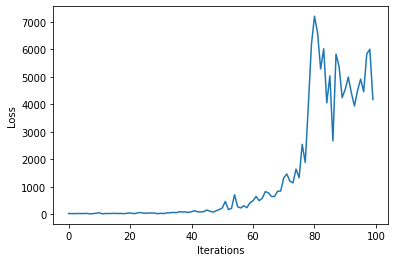

In [26]:
plt.plot(result_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

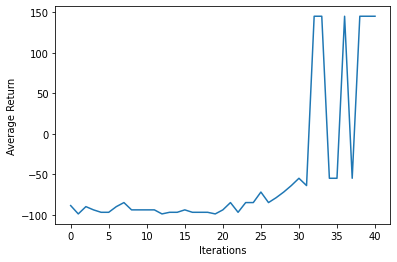

In [27]:
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

## Evaluation

In [22]:
observers = []
driver = py_driver.PyDriver(
    eval_env, PyTFEagerPolicy(agent.policy), observers, max_steps=1000, max_episodes=5)

In [23]:
time_spec_init = eval_env.reset()
driver.run(time_spec_init)

[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 1 1
[0 1 0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 0 0 0 0] 7 7
[0 1 0 0 0 0 0 1 0 0] 2
[0 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0 0 1 0 0] 3
[1 1 0 0 0 0 0 1 0 0] 0 0
[1 1 0 0 0 0

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}),
 ())

In [24]:
returns

[-88.7,
 -99.0,
 -90.0,
 -94.0,
 -97.0,
 -97.0,
 -90.0,
 -85.0,
 -94.0,
 -94.0,
 -94.0,
 -94.0,
 -99.0,
 -97.0,
 -97.0,
 -94.0,
 -97.0,
 -97.0,
 -97.0,
 -99.0,
 -94.0]